In [90]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, GridSearchCV,  RandomizedSearchCV
import math
from data import *
import pandas as pd
from itertools import islice
import seaborn as sns; sns.set_theme()
from imblearn.ensemble import BalancedRandomForestClassifier

In [91]:
bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')

In [54]:
display(bin_df.head())

,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,flux_434,flux_435,flux_436,flux_437,flux_438,flux_439,flux_440,primary_type,secondary_type,system_type
0,0.568345,0.615487,0.668477,0.705189,0.698754,0.700950,0.717146,0.704941,0.707754,0.723033,...,0.209508,0.203912,0.205196,0.201559,0.207766,0.209226,0.214793,16.0,16.0,16.0
1,0.496365,0.563067,0.602393,0.659527,0.682808,0.676481,0.674343,0.689054,0.676825,0.670386,...,0.213932,0.207528,0.206223,0.201853,0.205284,0.206424,0.206224,16.0,17.0,16.0
2,0.520227,0.580531,0.627045,0.645281,0.665795,0.678923,0.686509,0.685623,0.674414,0.702066,...,0.187648,0.184240,0.177598,0.175445,0.175319,0.181286,0.176042,16.0,16.0,16.0
3,0.483774,0.556865,0.603915,0.641451,0.698212,0.728678,0.666010,0.671234,0.659358,0.688617,...,0.233598,0.225866,0.234960,0.214639,0.219380,0.224144,0.224282,16.0,16.0,16.0
4,0.434787,0.504214,0.543165,0.611378,0.659270,0.680497,0.663214,0.634306,0.645955,0.654454,...,0.218515,0.209248,0.202981,0.198711,0.201315,0.201008,0.202865,16.0,16.0,16.0


In [ ]:
def add_noise(data):
        """Adds noise between 2 and 5 percent to the binary dataset for any flux matrix"""
        n1, n2 = 0, random.uniform(0.02, 0.05)
        noise = np.random.normal(n1, n2, [len(data), 441])
        noisefunc = np.append(noise, np.zeros((len(data),1)), axis = 1)
        noisyfluxfunc = np.add(data.astype(float), noisefunc)
        return noisyfluxfunc

#Experiment comparing noise vs no noise on different folds
noise_accuracies = []
raw_accuracies = []

for i in range(10): #For each sample or fold
    binary_sample = bin_df.sample(n = len(sin_df.index))

    #Preprocess data
    x = np.insert(np.arange(441), 0, -1)
    bin_data = binary_sample.iloc[:,x].to_numpy()
    x[0] = -2
    sin_data = sin_df.iloc[:,x].to_numpy()
    
    #Create raw data
    raw_data, raw_labels = add_labels(bin_data, sin_data)

    #Create noise data
    noise_sin = add_noise(sin_data)
    noise_bin = add_noise(bin_data)
    noise_data, noise_labels = add_labels(noise_bin, noise_sin)

    #Create training and test data
    noise_train_data, noise_train_labels = noise_data[:int(len(noise_data)*0.8)], noise_labels[:int(len(noise_data)*0.8)]
    noise_test_data, noise_test_labels = noise_data[int(len(noise_data)*0.8):], noise_labels[int(len(noise_data)*0.8):]

    raw_train_data, raw_train_labels = raw_data[:int(len(raw_data)*0.8)], raw_labels[:int(len(raw_data)*0.8)]
    raw_test_data, raw_test_labels = raw_data[int(len(raw_data)*0.8):], raw_labels[int(len(raw_data)*0.8):]
    
    noise_RF = RandomForestClassifier(random_state = 0)
    noise_RF.fit(noise_train_data, noise_train_labels)
    n_acc = noise_RF.score(noise_test_data, noise_test_labels)

    raw_RF = RandomForestClassifier(random_state = 0)
    raw_RF.fit(raw_train_data, raw_train_labels)
    r_acc = raw_RF.score(raw_test_data, raw_test_labels)

    noise_accuracies.append(n_acc)
    raw_accuracies.append(r_acc)
    
    #Save best sample
    try:
        if n_acc > best_n_acc:
            np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-noise.npy', binary_sample)
            best_model_noise = noise_RF
            best_n_acc = n_acc
    except:
        np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-noise.npy', binary_sample)
        best_model_noise = noise_RF
        best_n_acc = n_acc
    try:
        if r_acc > best_r_acc:
            np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-raw.npy', binary_sample)
            best_model_raw = raw_RF
            best_r_acc = r_acc
    except:
        np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-raw.npy', binary_sample)
        best_model_raw = raw_RF
        best_r_acc = r_acc

    print('Noise Accuracy: ', n_acc)
    print('Raw Accuracy: ', r_acc)

print('raw accuracy:', raw_accuracies)
print('noise accuracy:', noise_accuracies)

In [93]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a).astype(float)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

class data():
    def __init__(self, use_noise = False, snr = False):

        self.snr = snr
        self.use_noise = use_noise
        self.bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')
        self.sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')
        
        self.bin_df = self.bin_df.loc[(self.bin_df['primary_type'] <= 27) & (self.bin_df['primary_type'] >= 17)]
        self.bin_df = self.bin_df.loc[(self.bin_df['secondary_type'] <= 38) & (self.bin_df['secondary_type'] >= 31)]
        self.sin_df = self.sin_df.loc[(self.sin_df['spectral_type'] <= 27) & (self.sin_df['spectral_type'] >= 17)]
        self.freq_map(self.bin_df)

        #preprocess
        x = np.insert(np.arange(441), 0, -1)
        self.bin_data = self.bin_df.iloc[:,x].to_numpy()
        x[0] = -2
        self.sin_data = self.sin_df.iloc[:,x].to_numpy()

        temp_bin = self.bin_data
        temp_sin = self.sin_data
        
        for _ in range(0):
            self.bin_data = np.concatenate((self.bin_data, temp_bin), axis = 0)
            self.sin_data = np.concatenate((self.sin_data, temp_sin), axis = 0)

        if self.use_noise:
            self.bin_data = self.add_noise(self.bin_data)
            self.sin_data = self.add_noise(self.sin_data)

        if self.snr: self.add_snr()
        data, labels = add_labels(self.bin_data, self.sin_data)
        
        #Create training and test data
        self.train_data, self.train_labels = data[:int(len(data)*0.8)], labels[:int(len(data)*0.8)]
        self.test_data, self.test_labels = data[int(len(data)*0.8):], labels[int(len(data)*0.8):]
        
    def add_snr(self):
        temp_bin = bin_df.to_numpy()
        temp_sin = sin_df.to_numpy()
        self.bin_data = np.concatenate((self.bin_data, np.expand_dims(signaltonoise(self.bin_data[:, :440], axis = 1), axis = 1)), axis = 1)
        temp = signaltonoise(temp_bin[:, :440], axis = 1)
        bin_df['snr'] = temp
        self.sin_data = np.concatenate((self.sin_data, np.expand_dims(signaltonoise(self.sin_data[:, :440], axis = 1), axis = 1)), axis = 1)
        temp = signaltonoise(temp_sin[:, :440], axis = 1)
        sin_df['snr'] = temp

    def sample_binaries(self):
        return self.bin_df.sample(n = len(sin_df.index))

    #From Malina's Code - Old Noise
    def add_noise(self,data):
        """Adds noise between 2 and 5 percent to the binary dataset for any flux matrix"""
        n1, n2 = 0, random.uniform(0.02, 0.05)
        noise = np.random.normal(n1, n2, [len(data), 441])
        noisefunc = np.append(noise, np.zeros((len(data),1)), axis = 1)
        noisyfluxfunc = np.add(data.astype(float), noisefunc)
        return noisyfluxfunc
    
    def get_data(self):
        return self.train_data, self.train_labels, self.test_data, self.test_labels

    def freq_map(self,sample):
        freq = np.zeros((23,23))
        for primary in range(23):
            for secondary in range(23):
                freq[primary,secondary] = len(sample.loc[(sample['primary_type'] == primary + 16) & (sample['secondary_type'] == secondary + 16)])
        plt.figure(figsize = (8,7), facecolor='white')
        ax = sns.heatmap(freq, cmap = "mako")
        labels = ['M6','M7','M8','M9','L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','T0','T1','T2','T3','T4','T5','T6','T7','T8']
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('10') 
        ax.set_ylabel('Primary')
        ax.set_xlabel('Seconday')
        ax.set_title('Frequency of Binaries in Sample')
        plt.savefig('sample-freq.png')

    def SNR(self):
        snr = signaltonoise(self.train_data, axis = 1)
        print(snr)

In [94]:
class experiment():
    def __init__(self, train_data, train_labels, test_data, test_labels, snr = False):
        self.best_model = None
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.snr = snr

    def run(self):
        self.best_model = BalancedRandomForestClassifier(random_state=0) #RandomForestClassifier(random_state = 0)
        self.best_model.fit(self.train_data, self.train_labels)
        self.accuracy = self.best_model.score(self.test_data, self.test_labels)
        bin_results, sin_results = self.grid_test(self.best_model)
        print('Model Accuracy', self.accuracy)
        return bin_results, sin_results

    def test(self, rf):
        self.accuracy = rf.score(self.test_data, self.test_labels)
        bin_results, sin_results = self.grid_test(rf)
        print('Model Accuracy', self.accuracy)
        return self.accuracy
        
    def grid_test(self,rf):
        if self.snr:
            prefix_title = "SNR "
            prefix_file = "snr-"
        else:
            prefix_title = ""
            prefix_file = ""

        bin_results = np.zeros((23,23))
        mirror_results = np.zeros((23,23))
        for primary in range(16,39):
            for secondary in range(16, 39):
                data = bin_df.loc[(bin_df['primary_type'] == primary) & (bin_df['secondary_type'] == secondary)]
                
                #print('test', primary, secondary, data.iloc[:,-5:])
                x = np.insert(np.arange(441), 0, -1)
                if self.snr: x = np.insert(x, 0, -2)

                data = data.iloc[:,x].to_numpy()
                try:
                    outputs = rf.predict(data)
                    accuracy = np.sum(outputs) / len(outputs)
                except:
                    accuracy = 0

                bin_results[primary - 16, secondary - 16] = accuracy

                if primary <= secondary:
                    mirror_data_a = bin_df.loc[(bin_df['primary_type'] == primary) & (bin_df['secondary_type'] == secondary)]
                    mirror_data_b = bin_df.loc[(bin_df['primary_type'] == secondary) & (bin_df['secondary_type'] ==  primary)]
                    mirror_data = pd.concat([mirror_data_a, mirror_data_b])
                    
                    x = np.insert(np.arange(441), 0, -1)
                    mirror_data = mirror_data.iloc[:,x].to_numpy()
                    try:
                        outputs = rf.predict(mirror_data)
                        accuracy = np.sum(outputs) / len(outputs)
                    except:
                        accuracy = 0

                    mirror_results[primary - 16, secondary - 16] = accuracy
                
        
        sin_results = np.zeros((23,1))
        for single in range(16,39):
            data = sin_df[(sin_df['spectral_type'] == single)]

            x = np.arange(441)
            if self.snr: 
                x = np.insert(x, 0, -3)
                x = np.insert(x, 0, -1)
            else:
                x = np.insert(x, 0, -2)
            data = data.iloc[:,x].to_numpy()
            
            outputs = rf.predict(data)
            accuracy = 1 - np.sum(outputs) / len(outputs)
            
            sin_results[single - 16,0] = accuracy
        
        
        self.acc_map(mirror_results, prefix_title + 'Mirrored Accuracy of Binaries in Sample', prefix_file + 'mirror-acc')
        self.acc_map(bin_results, prefix_title + 'Accuracy of Binaries in Sample', prefix_file + 'bin-acc')
        self.single_acc(sin_results, prefix_title + 'Accuracy of Single Stars', prefix_file + 'sin-acc')
        
        return bin_results, sin_results

    def acc_map(self,results, title, filename):
        plt.figure(figsize = (8,7), facecolor='white')
        ax = sns.heatmap(results, cmap = "mako")
        labels = ['M6','M7','M8','M9','L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','T0','T1','T2','T3','T4','T5','T6','T7','T8']
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('10') 
        ax.set_ylabel('Primary')
        ax.set_xlabel('Seconday')
        ax.set_title(title) #'Accuracy of Binaries in Sample'
        plt.savefig(filename)   #'sample-acc.png'

    def single_acc(self,results, title, filename):
        plt.figure(figsize = (3,7), facecolor='white')
        ax = sns.heatmap(results, cmap = "mako")
        labels = ['M6','M7','M8','M9','L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','T0','T1','T2','T3','T4','T5','T6','T7','T8']
        ax.set_yticklabels(labels)
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('10') 
        ax.set_ylabel('Spectral Type')
        ax.set_title(title) #'Accuracy of Single Stars'
        plt.savefig(filename) #'single-acc.png'

Run Experiment without SNR

data.py data shape: (7617, 442)
data.py data shape: (7617, 442)
data.py data shape: (7617, 442)
Model Accuracy 0.7992125984251969


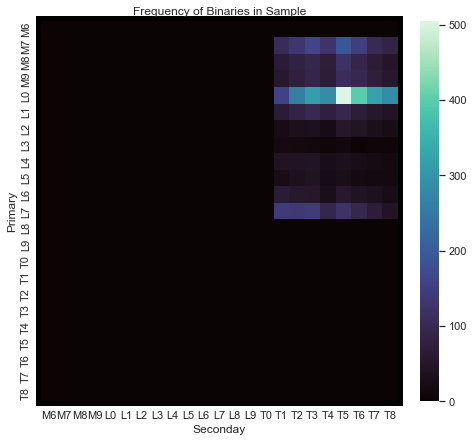

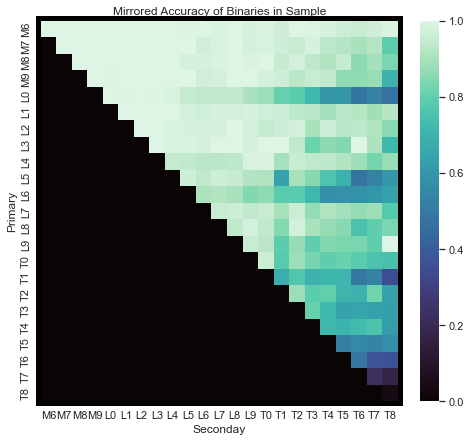

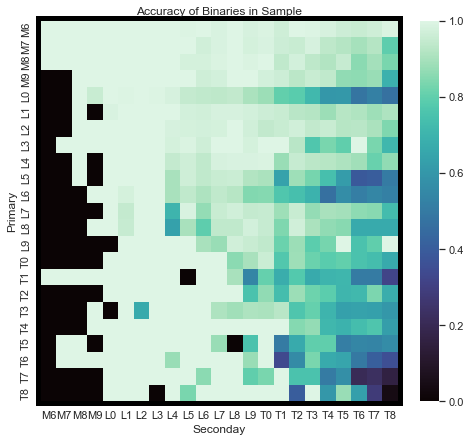

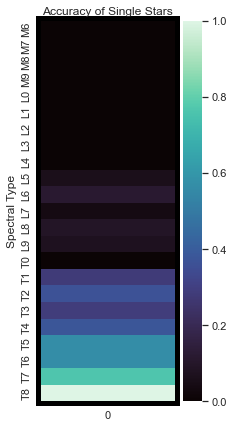

In [101]:
bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')
sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')

dataset = data()
train_data, train_labels, test_data, test_labels = dataset.get_data()
exp = experiment(train_data, train_labels, test_data, test_labels)
bin_results, sin_results = exp.run()

Run Experiment with SNR

data.py data shape: (7617, 443)
data.py data shape: (7617, 443)
data.py data shape: (7617, 443)
Model Accuracy 0.8149606299212598


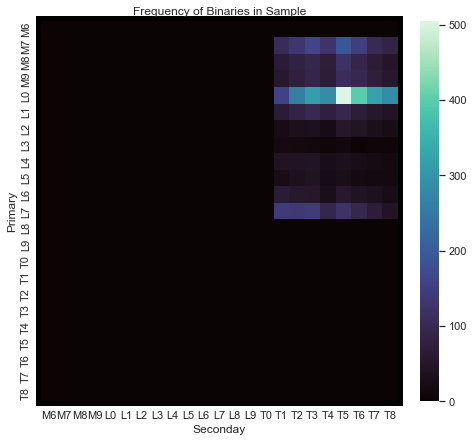

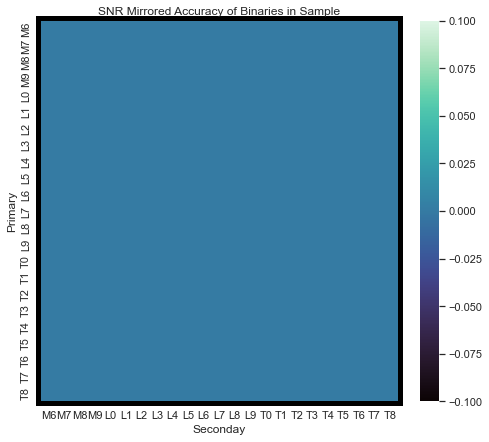

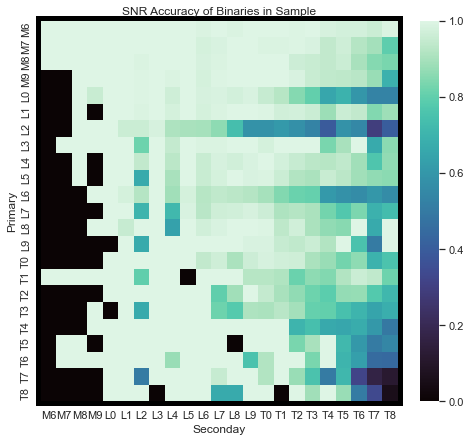

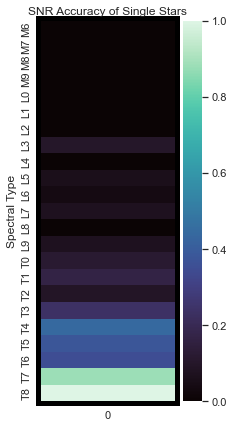

In [96]:
snr_data = data(snr = True)
train_data, train_labels, test_data, test_labels = snr_data.get_data()
snr_exp = experiment(train_data, train_labels, test_data, test_labels, snr = True)
bin_snr, sin_snr = snr_exp.run()

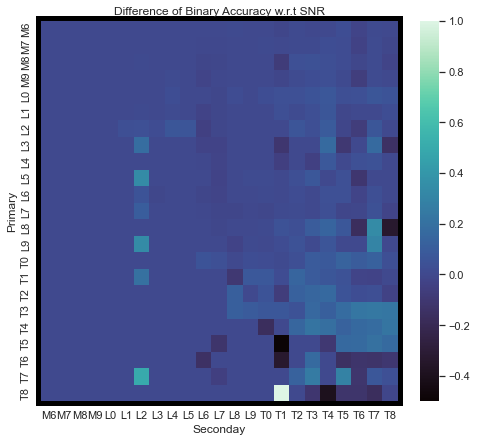

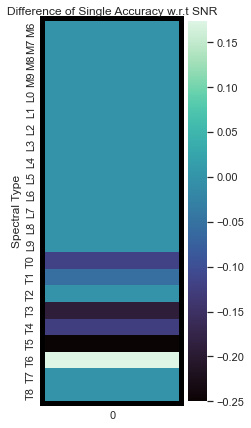

In [97]:
bin_diff = np.subtract(bin_results, bin_snr)
sin_diff = np.subtract(sin_results, sin_snr)
exp.acc_map(bin_diff, 'Difference of Binary Accuracy w.r.t SNR', 'bin-snr.png')
exp.single_acc(sin_diff, 'Difference of Single Accuracy w.r.t SNR', 'sin-snr.png')

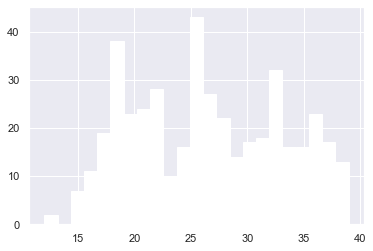

In [104]:
plt.hist(sin_df['spectral_type'], bins = 23, facecolor = 'white')
plt.savefig('sin-hist.png')

In [65]:
bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')

In [66]:
display(bin_df)

,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,flux_434,flux_435,flux_436,flux_437,flux_438,flux_439,flux_440,primary_type,secondary_type,system_type
0,0.568345,0.615487,0.668477,0.705189,0.698754,0.700950,0.717146,0.704941,0.707754,0.723033,...,0.209508,0.203912,0.205196,0.201559,0.207766,0.209226,0.214793,16.0,16.0,16.0
1,0.496365,0.563067,0.602393,0.659527,0.682808,0.676481,0.674343,0.689054,0.676825,0.670386,...,0.213932,0.207528,0.206223,0.201853,0.205284,0.206424,0.206224,16.0,17.0,16.0
2,0.520227,0.580531,0.627045,0.645281,0.665795,0.678923,0.686509,0.685623,0.674414,0.702066,...,0.187648,0.184240,0.177598,0.175445,0.175319,0.181286,0.176042,16.0,16.0,16.0
3,0.483774,0.556865,0.603915,0.641451,0.698212,0.728678,0.666010,0.671234,0.659358,0.688617,...,0.233598,0.225866,0.234960,0.214639,0.219380,0.224144,0.224282,16.0,16.0,16.0
4,0.434787,0.504214,0.543165,0.611378,0.659270,0.680497,0.663214,0.634306,0.645955,0.654454,...,0.218515,0.209248,0.202981,0.198711,0.201315,0.201008,0.202865,16.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110809,0.030098,0.014580,-0.007441,-0.006942,-0.007369,0.006425,0.016458,0.006826,-0.001549,0.020413,...,-0.000636,-0.005062,-0.001746,0.002502,0.002527,0.002917,0.003646,38.0,38.0,38.0
110810,0.005596,0.004737,-0.002069,0.010406,0.006171,0.009747,0.011305,0.008200,0.004347,0.014751,...,-0.001543,-0.004403,0.001089,0.004393,0.004432,0.004561,-0.000681,38.0,39.0,38.0
110848,0.073538,0.009197,-0.005860,-0.038976,-0.014792,-0.014072,0.036644,-0.001032,-0.009587,0.015874,...,0.003452,-0.007673,-0.005274,0.000802,0.001512,0.001638,0.005702,38.0,38.0,38.0
110849,0.001377,-0.014757,-0.004499,0.012407,-0.003643,-0.001074,0.012893,-0.004316,0.009678,-0.000535,...,-0.000068,-0.007200,0.002112,0.005037,0.006211,0.005238,-0.004113,38.0,39.0,39.0


In [67]:
x = np.insert(np.arange(441), 0, -1) #grabs all columns except the primary + secondary type
test_data = bin_df.iloc[:,x].to_numpy() #converts binary set into a numpy array without the primary + secondary type
a = exp.best_model.predict(test_data)   #predicts on the binary set

In [68]:
print(np.shape(test_data))

(42008, 442)


In [69]:
np.sum(a)

41126

In [70]:
41126 / 42008

0.9790039992382403

In [74]:
sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')
display(sin_df)

,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,flux_433,flux_434,flux_435,flux_436,flux_437,flux_438,flux_439,flux_440,spectral_type,object_name
0,0.494552,0.566051,0.614045,0.661532,0.686862,0.693291,0.702654,0.703600,0.686852,0.701040,...,0.215337,0.215931,0.205811,0.202409,0.200154,0.205162,0.200159,0.202379,16.0,2MASS J16002535-2644060
1,0.634512,0.657556,0.714886,0.740784,0.703573,0.701638,0.724311,0.699457,0.721232,0.737424,...,0.206600,0.201257,0.200105,0.205926,0.200983,0.208295,0.216014,0.224778,12.0,2MASS J17252029-0024508
2,0.493893,0.550069,0.571380,0.647315,0.666165,0.634119,0.608750,0.651115,0.648178,0.600103,...,0.229087,0.207245,0.208434,0.211384,0.202791,0.202994,0.216542,0.211448,15.0,2MASS J01532750+3631482
3,0.527926,0.576912,0.620860,0.613389,0.629185,0.647721,0.653567,0.651127,0.645000,0.683485,...,0.157152,0.158078,0.160547,0.151297,0.149293,0.144747,0.160000,0.148471,17.0,WISE J141143.25-452418.3
4,0.462815,0.535964,0.581080,0.607863,0.694902,0.748792,0.615324,0.624720,0.617972,0.661705,...,0.241278,0.246377,0.241199,0.262611,0.224629,0.229004,0.243447,0.241497,13.0,2MASS J19445221-0831036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,-0.004027,-0.007743,-0.004455,0.005451,0.001937,-0.002612,0.002762,0.003820,0.011900,0.006834,...,0.001825,0.003611,0.000533,0.003529,0.002783,0.006177,0.002361,0.000314,38.0,WISE J025409.51+022358.6
432,0.008489,0.009103,-0.001436,0.010861,0.008182,0.012516,0.011853,0.010578,0.003773,0.018182,...,-0.001485,-0.002331,-0.003116,0.000461,0.004334,0.003893,0.004213,0.000512,38.0,2MASSI J0415195-093506
433,-0.004778,0.078588,0.011728,-0.005535,0.033752,0.007601,-0.034531,-0.006146,-0.020120,0.007291,...,0.002653,0.000853,0.002269,-0.005126,0.019522,-0.002011,-0.015760,0.007481,37.0,WISE J132233.64-234016.8
434,0.073008,0.009225,-0.005804,-0.039170,-0.014236,-0.015112,0.038132,-0.001542,-0.009924,0.014488,...,0.011270,0.002495,-0.008254,-0.004863,0.001008,0.001313,0.001250,0.006463,38.0,WISE J222623.05+044004.0


In [79]:
y = np.insert(np.arange(441), 0, -2) #grabs all columns except the primary + secondary type
sin_test_data = sin_df.iloc[:,y].to_numpy() #converts binary set into a numpy array without the primary + secondary type
b = exp.best_model.predict(sin_test_data)   #predicts on the binary set

In [80]:
np.sum(b)

431

In [82]:
np.shape(exp.train_data)

(6093, 442)

In [72]:
6093 * 5 / 4

7616.25

In [73]:
228 + 7389

7617